# Plant Disease Detection of 'PlantDoc' Dataset, using Tensorflow Object Detection API
- dataset from https://github.com/pratikkayal/PlantDoc-Object-Detection-Dataset
  - Pascal VOC annotations cleaned up using util script in utils folder.
- this notebook referenced from https://github.com/nicknochnack/TFODCourse


# 0. Setup Paths

In [1]:
import os

CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

paths = {
    'WORKSPACE_PATH':           os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH':             os.path.join('Tensorflow', 'scripts'),
    'APIMODEL_PATH':            os.path.join('Tensorflow', 'models'),
    # 'ANNOTATION_PATH':          os.path.join('Tensorflow', 'workspace','annotations'),
    # 'IMAGE_PATH':               os.path.join('Tensorflow', 'workspace','images'),
    'IMAGE_PATH':               os.path.join('Tensorflow', 'workspace','PlantDoc-Object-Detection-Dataset-master'),
    'ANNOTATION_PATH':          os.path.join('Tensorflow', 'workspace','annotations'),
    
    'MODEL_PATH':               os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH':    os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH':          os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH':              os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':                os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':              os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':              os.path.join('Tensorflow', 'protoc')
}

files = {
    'PIPELINE_CONFIG':  os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP':         os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [2]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [3]:
if os.name=='nt':
    !pip install wget
    import wget

In [3]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

### Ad-hoc install additional missing packages until TFOD API working

In [ ]:
# !pip install pytz

In [ ]:
# !pip install pyyaml

In [ ]:
# !pip install --user tensorflow_addons
# !pip install gin-config
# !pip install tf-nightly

### Verify TFOD API working

In [5]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

Running tests under Python 3.10.4: c:\Anaconda\envs\tfcv\python.exe
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-09-19 16:17:30.295196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 16:17:30.999543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6621 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
c:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\model_builder.py:1102: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn(('Building experimental DeepMAC meta-arch.'
W091

In [9]:
# import object_detection

In [4]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

        1 file(s) moved.


x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


# 2. Create Label Map

In [5]:
import pandas as pd
train_labels = pd.read_csv(r'D:\code\_projects\_practice\TFODCourse-main\Tensorflow\workspace\PlantDoc-Object-Detection-Dataset-master\train_labels.csv')

In [6]:
classnames = train_labels['class'].unique().tolist()

labels = []
for i, name in enumerate(classnames): 
    labels.append({'id':i+1, 'name':name})

labels

[{'id': 1, 'name': 'Cherry leaf'},
 {'id': 2, 'name': 'Peach leaf'},
 {'id': 3, 'name': 'Corn leaf blight'},
 {'id': 4, 'name': 'Apple rust leaf'},
 {'id': 5, 'name': 'Potato leaf late blight'},
 {'id': 6, 'name': 'Strawberry leaf'},
 {'id': 7, 'name': 'Corn rust leaf'},
 {'id': 8, 'name': 'Tomato leaf late blight'},
 {'id': 9, 'name': 'Tomato mold leaf'},
 {'id': 10, 'name': 'Potato leaf early blight'},
 {'id': 11, 'name': 'Apple leaf'},
 {'id': 12, 'name': 'Tomato leaf yellow virus'},
 {'id': 13, 'name': 'Blueberry leaf'},
 {'id': 14, 'name': 'Tomato leaf mosaic virus'},
 {'id': 15, 'name': 'Raspberry leaf'},
 {'id': 16, 'name': 'Tomato leaf bacterial spot'},
 {'id': 17, 'name': 'Squash Powdery mildew leaf'},
 {'id': 18, 'name': 'grape leaf'},
 {'id': 19, 'name': 'Corn Gray leaf spot'},
 {'id': 20, 'name': 'Tomato Early blight leaf'},
 {'id': 21, 'name': 'Apple Scab Leaf'},
 {'id': 22, 'name': 'Tomato Septoria leaf spot'},
 {'id': 23, 'name': 'Tomato leaf'},
 {'id': 24, 'name': 'Soya

In [7]:
# labels = [
#     {'id':1, 'name':'axial1', }, 
#     {'id':2, 'name':'axial0', }, 
#     {'id':3, 'name':'coronal1', },
#     {'id':4, 'name':'coronal0', }, 
#     {'id':5, 'name':'sagittal1', }, 
#     {'id':6, 'name':'sagittal0', },
#     ]
    
with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Generate TF records

In [8]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

### get TF record generation utility 

In [26]:
# if not os.path.exists(files['TF_RECORD_SCRIPT']):
#     !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

#     https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py

### run util and generate TFRecords

In [8]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'TRAIN')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')}
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'TEST')}  -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')}


Traceback (most recent call last):
  File "d:\code\_projects\_practice\TFODCourse-main\Tensorflow\scripts\generate_tfrecord.py", line 172, in <module>
    tf.app.run()
  File "c:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\platform\app.py", line 36, in run
    _run(main=main, argv=argv, flags_parser=_parse_flags_tolerate_undef)
  File "c:\Anaconda\envs\tfcv\lib\site-packages\absl\app.py", line 308, in run
    _run_main(main, args)
  File "c:\Anaconda\envs\tfcv\lib\site-packages\absl\app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "d:\code\_projects\_practice\TFODCourse-main\Tensorflow\scripts\generate_tfrecord.py", line 162, in main
    tf_example = create_tf_example(group, path)
  File "d:\code\_projects\_practice\TFODCourse-main\Tensorflow\scripts\generate_tfrecord.py", line 116, in create_tf_example
    encoded_jpg = fid.read()
  File "c:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 114, in read
    self._preread_check()


Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Pre-trained Model Config to our training folder

In [9]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 file(s) copied.


# 5. Update Config For Transfer Learning

In [10]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [11]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [12]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, pipeline_config)

In [13]:
pipeline_config.model.ssd.loss.classification_loss

weighted_sigmoid_focal {
  gamma: 2.0
  alpha: 0.25
}

In [14]:
pipeline_config.model.ssd.num_classes = len(labels)
# pipeline_config.model.ssd.loss.classification_loss = weighted_softmax
pipeline_config.train_config.batch_size = 16
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [15]:
config_text = text_format.MessageToString(pipeline_config)

with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:
    f.write(config_text)

In [ ]:
# config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
# with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
#     f.write(config_text)   

# 6. Train the model

In [16]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [17]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

### Run in CLI

In [18]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000


### CLI train run results:

In [ ]:
"""
(tfcv) D:\code\_projects\_practice\TFODCourse-main>python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000
2022-09-19 17:59:57.014196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 17:59:57.341129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6621 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0919 17:59:57.580261 33104 mirrored_strategy.py:374] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0919 17:59:57.586761 33104 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0919 17:59:57.586761 33104 config_util.py:552] Maybe overwriting use_bfloat16: False
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\model_lib_v2.py:563: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function
W0919 17:59:57.601761 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\model_lib_v2.py:563: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from_function
INFO:tensorflow:Reading unweighted datasets: ['Tensorflow\\workspace\\annotations\\train.record']
I0919 17:59:57.607761 33104 dataset_builder.py:162] Reading unweighted datasets: ['Tensorflow\\workspace\\annotations\\train.record']
INFO:tensorflow:Reading record datasets for input file: ['Tensorflow\\workspace\\annotations\\train.record']
I0919 17:59:57.608261 33104 dataset_builder.py:79] Reading record datasets for input file: ['Tensorflow\\workspace\\annotations\\train.record']
INFO:tensorflow:Number of filenames to read: 1
I0919 17:59:57.608261 33104 dataset_builder.py:80] Number of filenames to read: 1
WARNING:tensorflow:num_readers has been reduced to 1 to match input file shards.
W0919 17:59:57.608261 33104 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:100: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
W0919 17:59:57.609761 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:100: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:235: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()
W0919 17:59:57.625762 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:235: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0919 18:00:01.506761 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
W0919 18:00:03.244261 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0919 18:00:04.254763 33104 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
C:\Anaconda\envs\tfcv\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-09-19 18:00:23.995296: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.423761 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.425261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.427262 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.428261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.430261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.431762 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.434262 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.435261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.437762 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
I0919 18:00:26.439261 33104 cross_device_ops.py:616] Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\deprecation.py:629: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
W0919 18:00:27.149261 31016 deprecation.py:554] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\deprecation.py:629: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
INFO:tensorflow:Step 100 per-step time 0.909s
I0919 18:01:57.663761 33104 model_lib_v2.py:705] Step 100 per-step time 0.909s
INFO:tensorflow:{'Loss/classification_loss': 0.8997551,
 'Loss/localization_loss': 0.33729076,
 'Loss/regularization_loss': 0.15322672,
 'Loss/total_loss': 1.3902726,
 'learning_rate': 0.0319994}
I0919 18:01:57.664261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.8997551,
 'Loss/localization_loss': 0.33729076,
 'Loss/regularization_loss': 0.15322672,
 'Loss/total_loss': 1.3902726,
 'learning_rate': 0.0319994}
INFO:tensorflow:Step 200 per-step time 0.402s
I0919 18:02:39.343261 33104 model_lib_v2.py:705] Step 200 per-step time 0.402s
INFO:tensorflow:{'Loss/classification_loss': 0.6393568,
 'Loss/localization_loss': 0.24703795,
 'Loss/regularization_loss': 0.15317638,
 'Loss/total_loss': 1.0395712,
 'learning_rate': 0.0373328}
I0919 18:02:39.343761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.6393568,
 'Loss/localization_loss': 0.24703795,
 'Loss/regularization_loss': 0.15317638,
 'Loss/total_loss': 1.0395712,
 'learning_rate': 0.0373328}
INFO:tensorflow:Step 300 per-step time 0.431s
I0919 18:03:21.231261 33104 model_lib_v2.py:705] Step 300 per-step time 0.431s
INFO:tensorflow:{'Loss/classification_loss': 0.70805913,
 'Loss/localization_loss': 0.23609766,
 'Loss/regularization_loss': 0.15307379,
 'Loss/total_loss': 1.0972306,
 'learning_rate': 0.0426662}
I0919 18:03:21.232762 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.70805913,
 'Loss/localization_loss': 0.23609766,
 'Loss/regularization_loss': 0.15307379,
 'Loss/total_loss': 1.0972306,
 'learning_rate': 0.0426662}
INFO:tensorflow:Step 400 per-step time 0.402s
I0919 18:04:01.187262 33104 model_lib_v2.py:705] Step 400 per-step time 0.402s
INFO:tensorflow:{'Loss/classification_loss': 0.59725934,
 'Loss/localization_loss': 0.21715096,
 'Loss/regularization_loss': 0.15299255,
 'Loss/total_loss': 0.9674029,
 'learning_rate': 0.047999598}
I0919 18:04:01.188761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.59725934,
 'Loss/localization_loss': 0.21715096,
 'Loss/regularization_loss': 0.15299255,
 'Loss/total_loss': 0.9674029,
 'learning_rate': 0.047999598}
INFO:tensorflow:Step 500 per-step time 0.406s
I0919 18:04:41.829761 33104 model_lib_v2.py:705] Step 500 per-step time 0.406s
INFO:tensorflow:{'Loss/classification_loss': 0.58501935,
 'Loss/localization_loss': 0.22609213,
 'Loss/regularization_loss': 0.15292613,
 'Loss/total_loss': 0.9640376,
 'learning_rate': 0.053333}
I0919 18:04:41.831261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.58501935,
 'Loss/localization_loss': 0.22609213,
 'Loss/regularization_loss': 0.15292613,
 'Loss/total_loss': 0.9640376,
 'learning_rate': 0.053333}
INFO:tensorflow:Step 600 per-step time 0.394s
I0919 18:05:21.704761 33104 model_lib_v2.py:705] Step 600 per-step time 0.394s
INFO:tensorflow:{'Loss/classification_loss': 0.61471015,
 'Loss/localization_loss': 0.26298624,
 'Loss/regularization_loss': 0.15288076,
 'Loss/total_loss': 1.0305772,
 'learning_rate': 0.0586664}
I0919 18:05:21.706261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.61471015,
 'Loss/localization_loss': 0.26298624,
 'Loss/regularization_loss': 0.15288076,
 'Loss/total_loss': 1.0305772,
 'learning_rate': 0.0586664}
INFO:tensorflow:Step 700 per-step time 0.380s
I0919 18:05:59.291761 33104 model_lib_v2.py:705] Step 700 per-step time 0.380s
INFO:tensorflow:{'Loss/classification_loss': 0.5450263,
 'Loss/localization_loss': 0.16523986,
 'Loss/regularization_loss': 0.15285197,
 'Loss/total_loss': 0.8631182,
 'learning_rate': 0.0639998}
I0919 18:05:59.293262 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.5450263,
 'Loss/localization_loss': 0.16523986,
 'Loss/regularization_loss': 0.15285197,
 'Loss/total_loss': 0.8631182,
 'learning_rate': 0.0639998}
INFO:tensorflow:Step 800 per-step time 0.376s
I0919 18:06:37.410262 33104 model_lib_v2.py:705] Step 800 per-step time 0.376s
INFO:tensorflow:{'Loss/classification_loss': 0.5121618,
 'Loss/localization_loss': 0.19481616,
 'Loss/regularization_loss': 0.15290155,
 'Loss/total_loss': 0.8598795,
 'learning_rate': 0.069333196}
I0919 18:06:37.411762 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.5121618,
 'Loss/localization_loss': 0.19481616,
 'Loss/regularization_loss': 0.15290155,
 'Loss/total_loss': 0.8598795,
 'learning_rate': 0.069333196}
INFO:tensorflow:Step 900 per-step time 0.382s
I0919 18:07:15.136761 33104 model_lib_v2.py:705] Step 900 per-step time 0.382s
INFO:tensorflow:{'Loss/classification_loss': 0.5666383,
 'Loss/localization_loss': 0.1385002,
 'Loss/regularization_loss': 0.1530438,
 'Loss/total_loss': 0.8581823,
 'learning_rate': 0.074666604}
I0919 18:07:15.139261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.5666383,
 'Loss/localization_loss': 0.1385002,
 'Loss/regularization_loss': 0.1530438,
 'Loss/total_loss': 0.8581823,
 'learning_rate': 0.074666604}
INFO:tensorflow:Step 1000 per-step time 0.390s
I0919 18:07:54.187761 33104 model_lib_v2.py:705] Step 1000 per-step time 0.390s
INFO:tensorflow:{'Loss/classification_loss': 0.50281703,
 'Loss/localization_loss': 0.12683943,
 'Loss/regularization_loss': 0.15327878,
 'Loss/total_loss': 0.7829352,
 'learning_rate': 0.08}
I0919 18:07:54.191261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.50281703,
 'Loss/localization_loss': 0.12683943,
 'Loss/regularization_loss': 0.15327878,
 'Loss/total_loss': 0.7829352,
 'learning_rate': 0.08}
INFO:tensorflow:Step 1100 per-step time 0.408s
I0919 18:08:35.120261 33104 model_lib_v2.py:705] Step 1100 per-step time 0.408s
INFO:tensorflow:{'Loss/classification_loss': 0.4989299,
 'Loss/localization_loss': 0.1787991,
 'Loss/regularization_loss': 0.15347,
 'Loss/total_loss': 0.831199,
 'learning_rate': 0.07999918}
I0919 18:08:35.121761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.4989299,
 'Loss/localization_loss': 0.1787991,
 'Loss/regularization_loss': 0.15347,
 'Loss/total_loss': 0.831199,
 'learning_rate': 0.07999918}
INFO:tensorflow:Step 1200 per-step time 0.394s
I0919 18:09:14.356762 33104 model_lib_v2.py:705] Step 1200 per-step time 0.394s
INFO:tensorflow:{'Loss/classification_loss': 0.44695872,
 'Loss/localization_loss': 0.19536027,
 'Loss/regularization_loss': 0.15365565,
 'Loss/total_loss': 0.7959746,
 'learning_rate': 0.079996705}
I0919 18:09:14.358262 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.44695872,
 'Loss/localization_loss': 0.19536027,
 'Loss/regularization_loss': 0.15365565,
 'Loss/total_loss': 0.7959746,
 'learning_rate': 0.079996705}
INFO:tensorflow:Step 1300 per-step time 0.392s
I0919 18:09:54.499261 33104 model_lib_v2.py:705] Step 1300 per-step time 0.392s
INFO:tensorflow:{'Loss/classification_loss': 0.49771798,
 'Loss/localization_loss': 0.15477917,
 'Loss/regularization_loss': 0.15387258,
 'Loss/total_loss': 0.8063698,
 'learning_rate': 0.0799926}
I0919 18:09:54.500762 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.49771798,
 'Loss/localization_loss': 0.15477917,
 'Loss/regularization_loss': 0.15387258,
 'Loss/total_loss': 0.8063698,
 'learning_rate': 0.0799926}
INFO:tensorflow:Step 1400 per-step time 0.409s
I0919 18:10:34.523761 33104 model_lib_v2.py:705] Step 1400 per-step time 0.409s
INFO:tensorflow:{'Loss/classification_loss': 0.48192203,
 'Loss/localization_loss': 0.14016016,
 'Loss/regularization_loss': 0.15404375,
 'Loss/total_loss': 0.7761259,
 'learning_rate': 0.07998685}
I0919 18:10:34.525261 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.48192203,
 'Loss/localization_loss': 0.14016016,
 'Loss/regularization_loss': 0.15404375,
 'Loss/total_loss': 0.7761259,
 'learning_rate': 0.07998685}
INFO:tensorflow:Step 1500 per-step time 0.391s
I0919 18:11:13.633261 33104 model_lib_v2.py:705] Step 1500 per-step time 0.391s
INFO:tensorflow:{'Loss/classification_loss': 0.4020088,
 'Loss/localization_loss': 0.08624531,
 'Loss/regularization_loss': 0.15412013,
 'Loss/total_loss': 0.6423743,
 'learning_rate': 0.07997945}
I0919 18:11:13.635761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.4020088,
 'Loss/localization_loss': 0.08624531,
 'Loss/regularization_loss': 0.15412013,
 'Loss/total_loss': 0.6423743,
 'learning_rate': 0.07997945}
INFO:tensorflow:Step 1600 per-step time 0.396s
I0919 18:11:54.173262 33104 model_lib_v2.py:705] Step 1600 per-step time 0.396s
INFO:tensorflow:{'Loss/classification_loss': 0.35510468,
 'Loss/localization_loss': 0.12919065,
 'Loss/regularization_loss': 0.15426378,
 'Loss/total_loss': 0.6385591,
 'learning_rate': 0.079970405}
I0919 18:11:54.177262 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.35510468,
 'Loss/localization_loss': 0.12919065,
 'Loss/regularization_loss': 0.15426378,
 'Loss/total_loss': 0.6385591,
 'learning_rate': 0.079970405}
INFO:tensorflow:Step 1700 per-step time 0.406s
I0919 18:12:33.820761 33104 model_lib_v2.py:705] Step 1700 per-step time 0.406s
INFO:tensorflow:{'Loss/classification_loss': 0.37620324,
 'Loss/localization_loss': 0.10105919,
 'Loss/regularization_loss': 0.1543449,
 'Loss/total_loss': 0.63160735,
 'learning_rate': 0.07995972}
I0919 18:12:33.822263 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.37620324,
 'Loss/localization_loss': 0.10105919,
 'Loss/regularization_loss': 0.1543449,
 'Loss/total_loss': 0.63160735,
 'learning_rate': 0.07995972}
INFO:tensorflow:Step 1800 per-step time 0.398s
I0919 18:13:13.626261 33104 model_lib_v2.py:705] Step 1800 per-step time 0.398s
INFO:tensorflow:{'Loss/classification_loss': 0.3618738,
 'Loss/localization_loss': 0.090322055,
 'Loss/regularization_loss': 0.1544511,
 'Loss/total_loss': 0.60664696,
 'learning_rate': 0.0799474}
I0919 18:13:13.628262 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.3618738,
 'Loss/localization_loss': 0.090322055,
 'Loss/regularization_loss': 0.1544511,
 'Loss/total_loss': 0.60664696,
 'learning_rate': 0.0799474}
INFO:tensorflow:Step 1900 per-step time 0.409s
I0919 18:13:54.596262 33104 model_lib_v2.py:705] Step 1900 per-step time 0.409s
INFO:tensorflow:{'Loss/classification_loss': 0.3941996,
 'Loss/localization_loss': 0.11833102,
 'Loss/regularization_loss': 0.15446164,
 'Loss/total_loss': 0.66699225,
 'learning_rate': 0.07993342}
I0919 18:13:54.597761 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.3941996,
 'Loss/localization_loss': 0.11833102,
 'Loss/regularization_loss': 0.15446164,
 'Loss/total_loss': 0.66699225,
 'learning_rate': 0.07993342}
INFO:tensorflow:Step 2000 per-step time 0.409s
I0919 18:14:35.459261 33104 model_lib_v2.py:705] Step 2000 per-step time 0.409s
INFO:tensorflow:{'Loss/classification_loss': 0.38075036,
 'Loss/localization_loss': 0.09505648,
 'Loss/regularization_loss': 0.15447344,
 'Loss/total_loss': 0.63028026,
 'learning_rate': 0.07991781}
I0919 18:14:35.460762 33104 model_lib_v2.py:708] {'Loss/classification_loss': 0.38075036,
 'Loss/localization_loss': 0.09505648,
 'Loss/regularization_loss': 0.15447344,
 'Loss/total_loss': 0.63028026,
 'learning_rate': 0.07991781}
"""

### Crap performance after 2000 steps, adding another 10000

### Irrelevant, checking tf-gpu

In [19]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')
# tf.test.is_built_with_gpu_support()

# tf.config.set_visible_devices([], 'GPU')
# CUDA_VISIBLE_DEVICES=""

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13030679235253060148
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6592749514
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5742226173955952247
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 7. Evaluate the Model

In [48]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [49]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


### CLI results:

In [ ]:
"""

(tfcv) D:\code\_projects\_practice\TFODCourse-main>python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet
WARNING:tensorflow:Forced number of epochs for all eval validations to be 1.
W0919 18:23:55.224261 29180 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0919 18:23:55.224261 29180 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0919 18:23:55.224761 29180 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0919 18:23:55.224761 29180 config_util.py:552] Maybe overwriting eval_num_epochs: 1
WARNING:tensorflow:Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
W0919 18:23:55.224761 29180 model_lib_v2.py:1106] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-09-19 18:23:55.226682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 18:23:55.538906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6340 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1
INFO:tensorflow:Reading unweighted datasets: ['Tensorflow\\workspace\\annotations\\test.record']
I0919 18:23:56.561761 29180 dataset_builder.py:162] Reading unweighted datasets: ['Tensorflow\\workspace\\annotations\\test.record']
INFO:tensorflow:Reading record datasets for input file: ['Tensorflow\\workspace\\annotations\\test.record']
I0919 18:23:56.562262 29180 dataset_builder.py:79] Reading record datasets for input file: ['Tensorflow\\workspace\\annotations\\test.record']
INFO:tensorflow:Number of filenames to read: 1
I0919 18:23:56.562262 29180 dataset_builder.py:80] Number of filenames to read: 1
WARNING:tensorflow:num_readers has been reduced to 1 to match input file shards.
W0919 18:23:56.562262 29180 dataset_builder.py:86] num_readers has been reduced to 1 to match input file shards.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:100: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
W0919 18:23:56.563762 29180 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:100: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.deterministic`.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:235: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()
W0919 18:23:56.636761 29180 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\builders\dataset_builder.py:235: DatasetV1.map_with_legacy_function (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.map()
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W0919 18:23:58.814263 29180 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0919 18:23:59.445263 29180 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Waiting for new checkpoint at Tensorflow\workspace\models\my_ssd_mobnet
I0919 18:24:00.914261 29180 checkpoint_utils.py:136] Waiting for new checkpoint at Tensorflow\workspace\models\my_ssd_mobnet
INFO:tensorflow:Found new checkpoint at Tensorflow\workspace\models\my_ssd_mobnet\ckpt-3
I0919 18:24:00.918762 29180 checkpoint_utils.py:145] Found new checkpoint at Tensorflow\workspace\models\my_ssd_mobnet\ckpt-3
C:\Anaconda\envs\tfcv\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-09-19 18:24:18.616326: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0919 18:24:19.290761 29180 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\util\dispatch.py:1082: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Finished eval step 0
I0919 18:24:19.297762 29180 model_lib_v2.py:966] Finished eval step 0
WARNING:tensorflow:From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\autograph\impl\api.py:459: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.

W0919 18:24:19.379262 29180 deprecation.py:350] From C:\Anaconda\envs\tfcv\lib\site-packages\tensorflow\python\autograph\impl\api.py:459: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.

INFO:tensorflow:Finished eval step 100
I0919 18:24:26.316762 29180 model_lib_v2.py:966] Finished eval step 100
INFO:tensorflow:Finished eval step 200
I0919 18:24:30.938761 29180 model_lib_v2.py:966] Finished eval step 200
INFO:tensorflow:Performing evaluation on 236 images.
I0919 18:24:32.648766 29180 coco_evaluation.py:293] Performing evaluation on 236 images.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
I0919 18:24:32.650264 29180 coco_tools.py:116] Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.01s)
I0919 18:24:32.659763 29180 coco_tools.py:138] DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.48s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.107
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.563
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.572
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.249
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.584
INFO:tensorflow:Eval metrics at step 2000
I0919 18:24:33.410762 29180 model_lib_v2.py:1015] Eval metrics at step 2000
INFO:tensorflow:    + DetectionBoxes_Precision/mAP: 0.107127
INFO:tensorflow:    + DetectionBoxes_Precision/mAP@.50IOU: 0.158049
INFO:tensorflow:    + DetectionBoxes_Precision/mAP@.75IOU: 0.126455
INFO:tensorflow:    + DetectionBoxes_Precision/mAP (small): 0.193247
INFO:tensorflow:    + DetectionBoxes_Precision/mAP (medium): 0.043969
INFO:tensorflow:    + DetectionBoxes_Precision/mAP (large): 0.110855
INFO:tensorflow:    + DetectionBoxes_Recall/AR@1: 0.367941
INFO:tensorflow:    + DetectionBoxes_Recall/AR@10: 0.563389
INFO:tensorflow:    + DetectionBoxes_Recall/AR@100: 0.572187
INFO:tensorflow:    + DetectionBoxes_Recall/AR@100 (small): 0.350000
INFO:tensorflow:    + DetectionBoxes_Recall/AR@100 (medium): 0.248810
INFO:tensorflow:    + DetectionBoxes_Recall/AR@100 (large): 0.584425
INFO:tensorflow:    + Loss/localization_loss: 0.152817
INFO:tensorflow:    + Loss/classification_loss: 0.712036
INFO:tensorflow:    + Loss/regularization_loss: 0.154474
INFO:tensorflow:    + Loss/total_loss: 1.019327
INFO:tensorflow:Waiting for new checkpoint at Tensorflow\workspace\models\my_ssd_mobnet
I0919 18:29:00.919765 29180 checkpoint_utils.py:136] Waiting for new checkpoint at Tensorflow\workspace\models\my_ssd_mobnet
"""

# 8. Load Train Model From Checkpoint

In [31]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [44]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-2')).expect_partial()

def resizeimage(image):
    image, shapes = detection_model.preprocess(image)
    return image, shapes

@tf.function
def detect_fn(image, shapes):
    # image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [45]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [46]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
category_index

{1: {'id': 1, 'name': 'Cherry leaf'},
 2: {'id': 2, 'name': 'Peach leaf'},
 3: {'id': 3, 'name': 'Corn leaf blight'},
 4: {'id': 4, 'name': 'Apple rust leaf'},
 5: {'id': 5, 'name': 'Potato leaf late blight'},
 6: {'id': 6, 'name': 'Strawberry leaf'},
 7: {'id': 7, 'name': 'Corn rust leaf'},
 8: {'id': 8, 'name': 'Tomato leaf late blight'},
 9: {'id': 9, 'name': 'Tomato mold leaf'},
 10: {'id': 10, 'name': 'Potato leaf early blight'},
 11: {'id': 11, 'name': 'Apple leaf'},
 12: {'id': 12, 'name': 'Tomato leaf yellow virus'},
 13: {'id': 13, 'name': 'Blueberry leaf'},
 14: {'id': 14, 'name': 'Tomato leaf mosaic virus'},
 15: {'id': 15, 'name': 'Raspberry leaf'},
 16: {'id': 16, 'name': 'Tomato leaf bacterial spot'},
 17: {'id': 17, 'name': 'Squash Powdery mildew leaf'},
 18: {'id': 18, 'name': 'grape leaf'},
 19: {'id': 19, 'name': 'Corn Gray leaf spot'},
 20: {'id': 20, 'name': 'Tomato Early blight leaf'},
 21: {'id': 21, 'name': 'Apple Scab Leaf'},
 22: {'id': 22, 'name': 'Tomato Sept

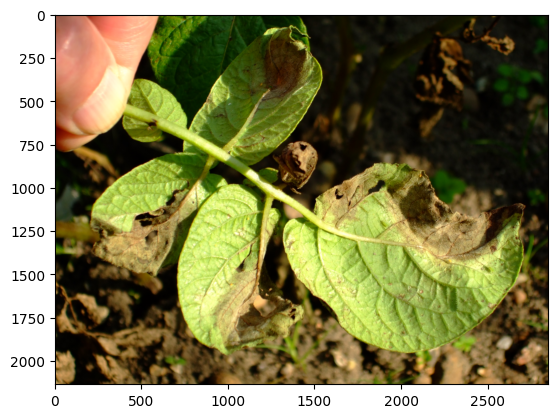

In [47]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'TEST', 'backus-056-potato-blight.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
image,shapes = resizeimage(input_tensor)
detections = detect_fn(image,shapes)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [ ]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [ ]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [ ]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')